# Carga de datos
Utilizamos un conjunto de datos de alrededor de 37000 reseñas de videos de Amazon Instant Video y 1700000 reseñas de películas y programas de televisión, todas obtenidas del sitio web: http://jmcauley.ucsd.edu/data/amazon/. Tenga en cuenta que hay conjuntos de datos mucho más grandes disponibles en el mismo sitio. Podemos esperar resultados mejores y más consistentes en conjuntos de datos más grandes (como reseñas de libros). Tenga en cuenta que estos conjuntos de datos están comprimidos (gzip) y están en formato JSON, cada línea representa una revisión y cada línea es su propio objeto JSON.

Comenzamos cargando el conjunto de datos a continuación:

In [1]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU times: user 1.59 s, sys: 276 ms, total: 1.87 s
Wall time: 2.83 s


True

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en dr
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


**Problema de negocio**. Su tarea principal es explorar los datos proporcionados y utilizar los resultados de su investigación para diseñar funciones relevantes que podrían facilitar el análisis posterior y la creación de modelos.

In [3]:
%%time
# podemos decirle a pandas que nuestro archivo esta en formato gzip y realizara el proceso de descompresion
# para esto usamos el atributo `lines=True` para indicar que cada linea en el archivo tiene su propio JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')
# ----------
# El archivo Películas y TV es muy grande. Si tienes problemas para cargarlo, puedes cargar solo los primeros
# 100,000 reseñas usando 'chunksize' (elimine el comentario de la línea con 'chunksize' y comente la línea
# después de lo que carga el archivo completo en `movies_tv`). Todo el análisis puede ser
# hecho de la misma manera utilizando solo el subconjunto de revisiones, pero algunos de los resultados pueden ser diferentes de los ejemplos.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
#movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

CPU times: user 4.04 s, sys: 661 ms, total: 4.7 s
Wall time: 6.96 s


Miremos algunos de los atributos

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.

In [4]:
print(len(instant_video))
instant_video.head(5)

37126


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [5]:
print(len(movies_tv))
movies_tv.head(5)

100000


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,"12 22, 2013"


Notamos que `movies_tv` es extremadamente larga con casi 2 millones de reseñas, y varias columnas parecen poco interesantes o difíciles de trabajar (por ejemplo, `reviewerID`, `asin`, `reviewername`, `reviewtime`). Dejamos caer alguna información para hacer que algunos de nuestros análisis posteriores sean más eficientes. También agregamos una columna de fecha y hora con objetos de fecha y hora de Python para resumir más fácilmente los datos:

Comenzamos cargando el conjunto de datos a continuación:

In [6]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 371 ms


In [7]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


# Histogramas de conteos

<Axes: >

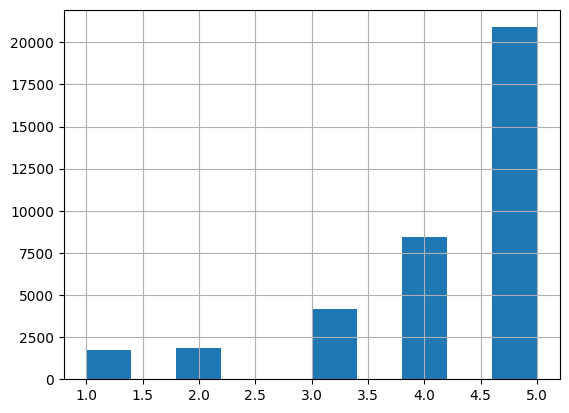

In [8]:
instant_video.overall.hist()

<Axes: >

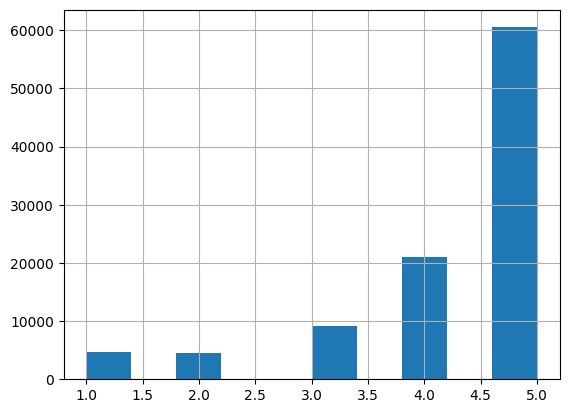

In [9]:
movies_tv.overall.hist()

Notamos eso:

1. La mayoría de las reseñas son buenas; de hecho, ¡más de la mitad son perfectas (5/5 estrellas) en ambos conjuntos de datos!
2. Casi todas las revisiones de videos instantáneos son extremadamente recientes. Será muy difícil detectar tendencias sin corregir esto. Las reseñas de TV Movie están sustancialmente más dispersas (aunque también incluyen un pico reciente).

# Promedio de ratings en el tiempo

In [10]:
instant_video.groupby(instant_video.datetime.dt.year)['overall'].mean()

datetime
2000    5.000000
2004    4.000000
2006    4.937500
2007    4.245763
2008    4.298701
2009    4.251381
2010    4.093085
2011    4.012414
2012    4.111845
2013    4.251077
2014    4.193535
Name: overall, dtype: float64

<Axes: xlabel='datetime'>

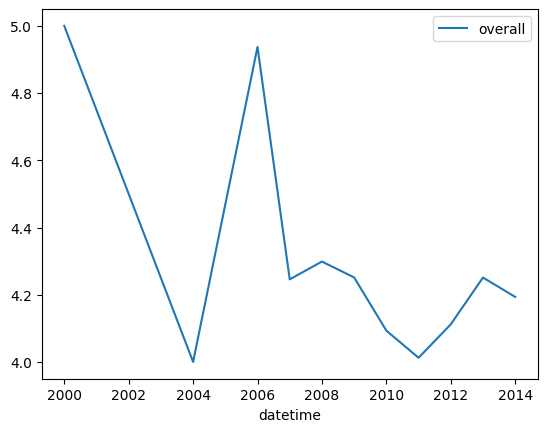

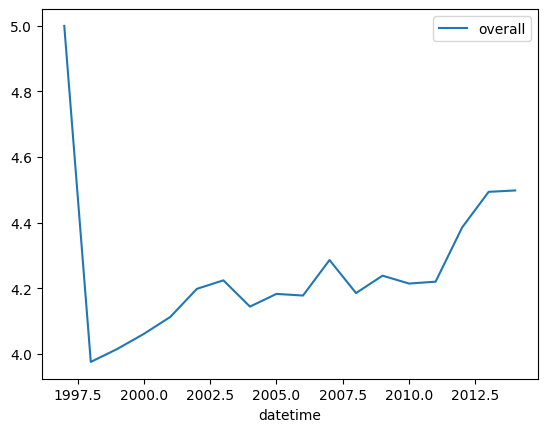

In [11]:
instant_video.groupby(instant_video.datetime.dt.year)['overall'].mean().to_frame().plot(kind="line")
movies_tv.groupby(movies_tv.datetime.dt.year)['overall'].mean().to_frame().plot(kind="line")

Notamos eso:

1. No hay tendencias notables de cambio de calificaciones con el tiempo.

2. Hay algunos años atípicos con calificaciones más altas, pero estos son años en los que la cantidad de revisiones es muy pequeña, lo que hace que el promedio sea menos confiable.

# Promedios longitudes de revisiones por año

In [12]:
instant_video['reviewText'].apply(len)

0         159
1         186
2         134
3         141
4        1300
         ... 
37121     150
37122    2111
37123     879
37124     173
37125     393
Name: reviewText, Length: 37126, dtype: int64

<Axes: xlabel='datetime'>

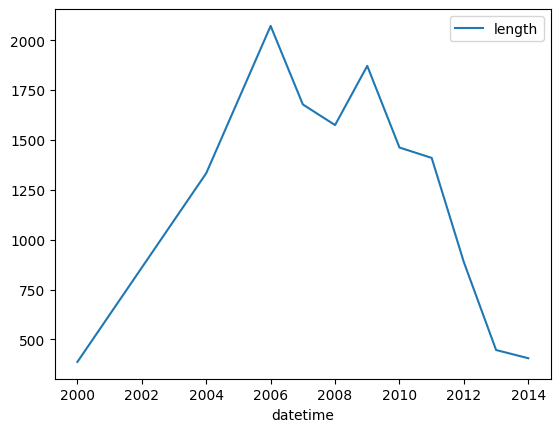

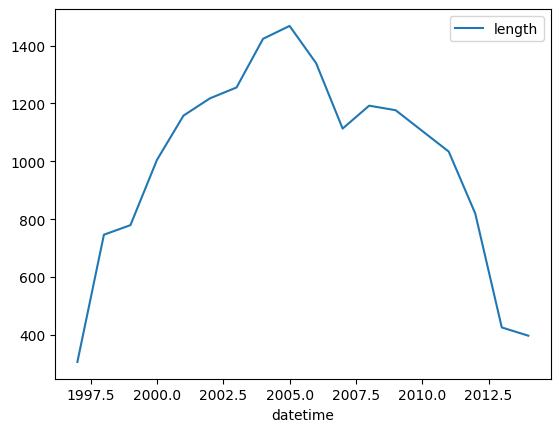

In [13]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="line")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="line")

Observamos una aparente tendencia al alza en la duración de las reseñas durante la década de 1990 y principios de la de 2000, seguida de una tendencia a la baja. Debido a que ambos conjuntos de datos tienen revisiones más recientes, la tendencia a la baja en la duración de la revisión es más confiable.

# Encontrar palabras mas frecuentes

Encontremos las diez palabras sin stopwrods que aparecen con mayor frecuencia en: (i) todas las reseñas, (ii) reseñas positivas, (iii) reseñas negativas. ¿Te sorprenden los resultados? ¿Por qué o por qué no?

In [14]:
movies_tv.overall.value_counts()

5    60511
4    21022
3     9166
1     4726
2     4575
Name: overall, dtype: int64

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
TfidfVectorizer?

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

short_movies_tv = movies_tv.head(100000)

def get_top_n_words(corpus, n=1, k=1):
    t1 = datetime.now()
    vec = CountVectorizer(ngram_range=(k, k), stop_words="english")
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

blu ray 8138
special effects 4939
ve seen 4739
great movie 4647
good movie 3391
sci fi 2728
love movie 2718
years ago 2594
quot quot 2527
don know 2494
movie great 2393
black white 2251
watch movie 2198
special features 2193
year old 2191
new york 2095
seen movie 1979
movie just 1938
great film 1932
highly recommend 1861
CPU times: user 44.6 s, sys: 1.24 s, total: 45.8 s
Wall time: 50.2 s


<Axes: title={'center': 'Top 20 words from all reviews'}, xlabel='words'>

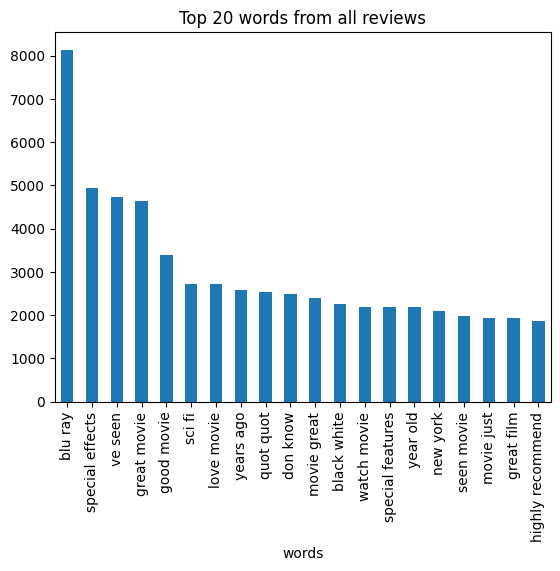

In [19]:
%%time
# Todos los reviews
common_words = get_top_n_words(short_movies_tv["reviewText"], n=20, k=2)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=["words", "count"])
df.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 words from all reviews"
)

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
print(len(stops))
print(stops)

179
{'were', 've', "wasn't", 'when', 'above', 'what', 'own', 'm', "shouldn't", 'an', 'shan', "you've", 'needn', 'wasn', 'between', 'we', 'whom', 'should', 'how', 'theirs', "aren't", 'had', 'myself', 'itself', 'will', 'other', 'from', 're', 'ourselves', 'its', 'you', "you'd", 'himself', "mightn't", 'again', "isn't", 'yourself', 's', 'this', "wouldn't", 'she', 'most', 'no', 'y', 'as', 'doing', 'of', 'be', 'was', 'only', 'after', 'while', 'his', 'are', 'until', 'my', 'have', "didn't", 'the', 'before', 'hadn', 'did', 'these', 'below', 'then', 'where', "it's", 'd', 'into', 'been', 'about', 'which', 'here', 'hers', 'few', 't', 'nor', 'aren', 'yours', 'for', 'such', 'themselves', 'same', 'because', 'off', 'it', 'all', 'during', 'in', 'didn', 'they', 'not', "hasn't", 'that', 'up', "needn't", 'shouldn', 'mightn', 'too', 'why', "weren't", 'am', 'isn', 'through', "you're", 'is', 'he', 'some', 'with', 'now', 'them', "won't", 'weren', 'any', 'just', 'does', 'down', "she's", 'but', 'those', 'being',

movie 115580
film 93835
great 41013
like 37190
quot 34366
good 34320
time 32859
just 31716
story 28559
best 24257
dvd 23076
love 22405
really 22185
movies 21329
watch 18387
life 17972
people 17203
way 16891
films 16620
don 15604
CPU times: user 13 s, sys: 125 ms, total: 13.1 s
Wall time: 14.4 s


<Axes: title={'center': 'Top 20 words from good reviews'}, xlabel='words'>

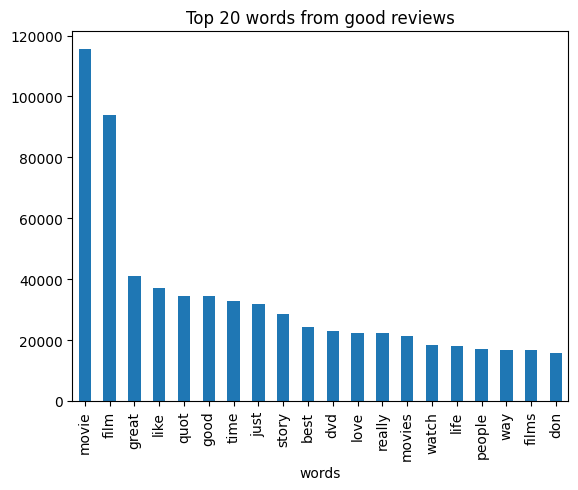

In [20]:
%%time
# reviews Positivos
good_indices = short_movies_tv["overall"] > 3.1
good_reviews = short_movies_tv[good_indices]
bad_indices = short_movies_tv["overall"] < 2.1
bad_reviews = short_movies_tv[bad_indices]

common_words = get_top_n_words(good_reviews["reviewText"], 20)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=["words", 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from good reviews'
)

movie 16098
film 10802
like 6400
just 6185
quot 5348
good 4302
time 3401
really 3311
don 3164
story 3005
bad 2919
people 2603
dvd 2572
make 2366
movies 2350
better 2255
did 2202
way 2198
great 2185
character 2158
CPU times: user 1.5 s, sys: 41.6 ms, total: 1.55 s
Wall time: 1.52 s


<Axes: title={'center': 'Top 20 words from bad reviews'}, xlabel='words'>

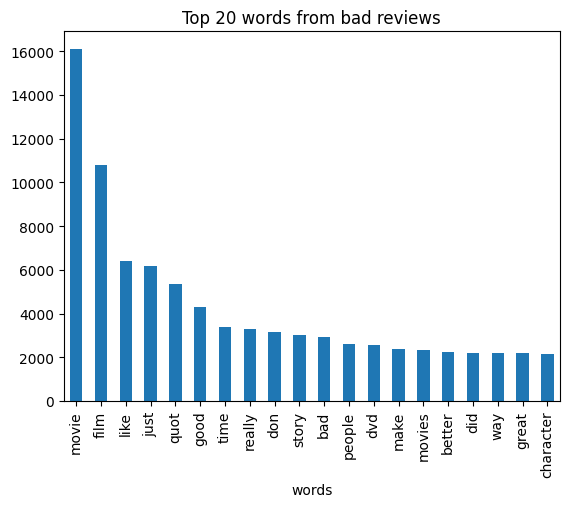

In [21]:
%%time
# reviews Negativos
common_words = get_top_n_words(bad_reviews['reviewText'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from bad reviews'
)

Tengan en cuenta que los resultados son casi idénticos en los tres grupos de reseñas: casi todas las palabras más importantes son palabras genéricas muy comunes sobre películas (es decir, "película" en sí). Como vimos en el caso anterior, esto no es tan sorprendente, dado que estamos tratando con datos en un contexto específico de una película, y las palabras vacías solo tendrán en cuenta las palabras genéricas que aparecen en muchos contextos en inglés, las stopwords más comunes serán el vocabulario básico relacionado con las películas, no necesariamente palabras más precisas que den más color a las reseñas en sí.

Encuentremos las palabras que sean indicativas de malas críticas. Es decir, palabras que aparecen a menudo en malas críticas y no en buenas críticas. ¿Qué son estas palabras y son sorprendentes?

CPU times: user 5.12 s, sys: 1.33 s, total: 6.44 s
Wall time: 6.31 s


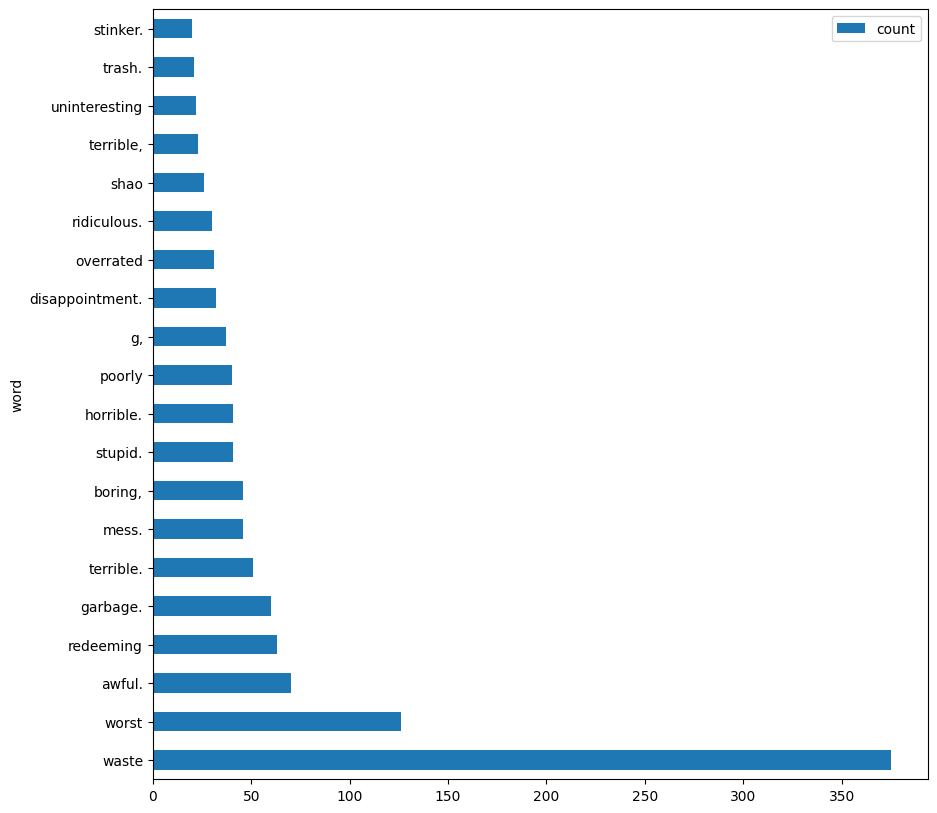

In [22]:
%%time
from collections import Counter

def get_indicative_words(text1, text2, n=20):
    c1 = Counter(text1.lower().split(" "))
    c2 = Counter(text2.lower().split(" "))
    ind_words_1 = (c1 - c2).most_common(n)
    ind_words_2 = (c2 - c1).most_common(n)
    x, y = zip(*ind_words_2)

    df = pd.DataFrame({'word': x, 'count': y})
    df.plot.barh(
        x='word', y='count', figsize=(10,10)
    )

get_indicative_words(' '.join(good_reviews['reviewText']), ' '.join(bad_reviews['reviewText']))

Notamos que muchas de las palabras son obviamente indicativas de una mala película, como "horrible", "decepción", "horrible". "Canjeable" es una palabra interesante que no tiene una asociación negativa obvia, pero probablemente indica que incluso en las críticas negativas, los revisores tienden a hablar de "una característica de redimir algo" (o afirman que la película). También hay algo de ruido en los datos, como es normal en los datos de texto. "g" y "shao" no parecen palabras significativas.

## Vamos por acá!!!

Inspeccionemos manualmente las primeras 10 reseñas negativas que contengan la palabra "buena". ¿Que notaste? ¿Cómo sugiere esto que debemos proceder a continuación?

In [30]:
bad_reviews.iloc[0:10]['reviewText'][20]

'We began watching this video, but stopped it a short way into it when we realized this was not what we had hoped for.  It was too contrived and predictable.'

Una posible solución se da a continuación. Tenga en cuenta que el uso de códigos de escape Ansi para colorear es un "buen extra" y no se espera necesariamente de las soluciones de los estudiantes:

In [31]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

'''
ANSI= American National Standards Institute se asocia con ASCII
RED_START = "\033[91m": Setea el color. 91 en ANSI code es para color rojo.
END = "\033[0m": Resetea el texto y color a formato comun
'''
RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:1000]:
    good_i = rev.lower().index("good")

    # adicionamos los codigos Ansi para hacer un highlight a los matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

1266
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of cor

Vemos que "bueno" se usa de diferentes maneras en las críticas negativas. Por ejemplo:

1. A veces, el revisor señala algo que es realmente bueno, antes de decir que esto no compensa problemas más importantes.
2. A veces, el crítico dice que algo bueno no está presente, ya que "casi todo lo que he visto hasta ahora no se parece al buen cine de ninguna manera".
3. De vez en cuando, la palabra "bueno" se refiere a la moralidad.

Revise la lista de malas críticas que contienen la palabra "buena" que encontramos en la última pregunta. Para cada revisión, extraiga lo siguiente:

1. La primera palabra después de "good"
2. La primera palabra después de "good" que es un sustantivo o cardinal
3. La última palabra antes de "good" que es un sustantivo o cardinal

In [33]:
# PArte i
import re

post_good = []
for sentence in good_word_bad_review:

    # extraer la palabra seguida de good. Hacemos un strip de caracteres
    post = re.search("good.?\W*(\w+).*\s?", sentence, re.IGNORECASE)

    # si good es la ultima palabra en el review no habra palabra
    # despues de ella
    if post:
        post_good.append(post.groups()[0])

post_good = [i for i in post_good if i]
print(post_good[0:20])

['the', 'but', 'for', 'plot', 'cinema', 'and', 'or', 'and', 'because', 'to', 'review', 'and', 'film', 'music', 'grief', 'box', 'comes', 'chance', 'After', 'actor']


In [ ]:
# Parte ii
nltk.download('averaged_perceptron_tagger')
good_pos = ['CD', 'FW', 'NN', 'NNS', 'NNP', 'NNPS']

def extract_interesting(sentence, good):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k, v in nltk.pos_tag(words) if v in good]
    return(interesting)

# Usamos esto para definir una nueva funcion para la proxima palabra interesante
def next_word2(sentence):
    post = re.findall(r'good.*', sentence)
    if len(post) > 0:
        interesting = extract_interesting(post[0], good_pos)
        if (len(interesting) > 0):
            return(interesting[0])
        else:
            return('')
    else:
        return('')

# Finalmente, buscamos en nuestra lista
post_good2 = []

for sentence in good_word_bad_review[:1000]:
    temp = next_word2(sentence)
    post_good2.append(temp)

post_good2 = [i for i in post_good2 if i]
print(post_good2[0:10])


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['story', 'scene', 'plot', 'cinema', 'history', 'benefit', 'scenes.To', 'filmmaker', 'extent', 'review']


In [ ]:
# parte III
# funcion para extraer palabras antes  de que parezca la palabra "good"

def prev_word(sentence):
    post = re.findall(r'.*?good', sentence)
    if (len(post) > 0):
        temp = extract_interesting(post[0],good_pos)
        if (len(temp) > 0):
            return(temp[len(temp)-1])
        else:
            return('')
    else:
        return('')

# Encontramos nuestra lista
pre_good = []
for sentence in good_word_bad_review[:1000]:
    temp = prev_word(sentence)
    pre_good.append(temp)

pre_good = [i for i in pre_good if i]
print(pre_good[0:10])

['acting', 'transfer', 'story', 'everything', 'acting', 'nothing', 'flashbacks', 'symbol', '.They', 'film']


# n-grams

Hemos visto que las palabras individuales no siempre son muy informativas. Busque los bigramas y trigramas más informativos, tanto en reseñas positivas como negativas. Muestre los bigramas y trigramas más informativos y haga un breve análisis de los n-gramas que identificó.

In [ ]:
def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

blu ray 6714
great movie 4300
ve seen 3895
special effects 3830
good movie 2669
love movie 2509
sci fi 2246
years ago 2191
movie great 2152
quot quot 1935
black white 1927
special features 1874
watch movie 1853
don know 1824
highly recommend 1812
year old 1799
seen movie 1774
new york 1720
great film 1683
real life 1471


<Axes: title={'center': 'Top 20 bigrams from good reviews'}, xlabel='words'>

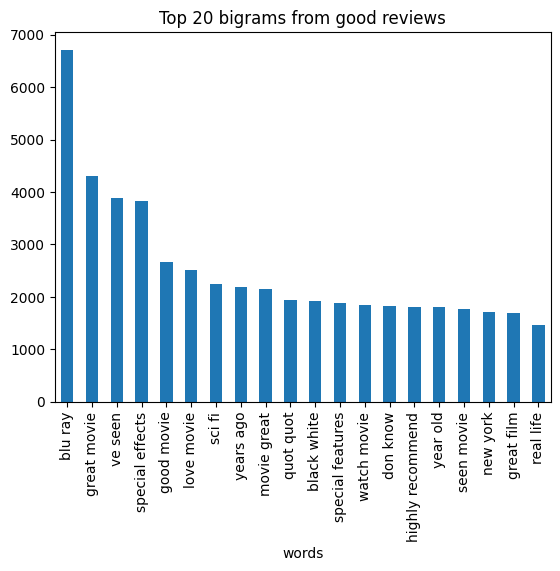

In [ ]:
# Bigramas con buenas revisiones
common_words = get_top_n_words(good_reviews['reviewText'], 20, 2)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams from good reviews'
)

tommy lee jones 779
nightmare elm street 640
does great job 467
world war ii 456
did great job 433
new york city 427
blu ray version 412
ve seen movie 383
highly recommend movie 350
based true story 344
blu ray release 316
does good job 310
did good job 283
country old men 273
special edition dvd 265
movie ve seen 262
dvd blu ray 251
haven seen movie 250
movies ve seen 247
does excellent job 216


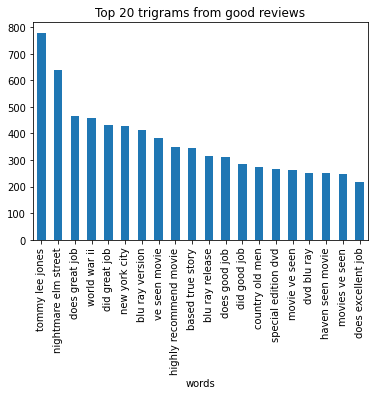

In [ ]:
# trigramas para buenas revisiones
common_words = get_top_n_words(good_reviews['reviewText'], 20, 3)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams from good reviews'
)

Algunos de los bigramas y trigramas están claramente relacionados con el tema, pero no necesariamente con buenas críticas. Por ejemplo, "blu ray", "lanzamiento de blu ray", "tommy lee jones", "historia real basada".

Otros están más obviamente relacionados específicamente con buenas críticas, como "hace un trabajo excelente", "muy recomendable", "gran película".

Las palabras importantes como "bueno" (así como las que aparecen en los otros n-gramas anteriores) tienden a ser adjetivos. Los adjetivos describen sustantivos. Más específicamente, un adjetivo casi siempre describe el sustantivo que le sigue y que está más cerca de él en una oración. A veces los adjetivos no van directamente después. Por ejemplo, "Esta fue una película buena e interesante" todavía tiene "buena" y "película" vinculadas.

Esto sugiere que podemos usar el etiquetado POS para extraer las ubicaciones de los adjetivos y sustantivos, luego iterar a través de todos los adjetivos y contar hacia adelante desde cada uno hasta llegar al siguiente sustantivo. Estas son nuestras palabras informativas.

Escribamos una(s) función(es) que transforme una oración en una nueva lista de texto emparejando iterativamente cada adjetivo en la oración con el siguiente sustantivo que le sigue en la oración. Por ejemplo, el texto "Esa fue una película larga y buena" debería devolver ["buena película", "película larga"].

In [ ]:
#Hacemos una función que toma el primer adjetivo y su sustantivo asociado, luego devuelve (i) el par y (ii) una oración más corta.
def grab_first_pair(sentence):
    words = nltk.word_tokenize(sentence)
    adjectives = [k for k, v in nltk.pos_tag(words) if v == 'JJ']
    if(len(adjectives) > 0):
        shorter = re.findall(adjectives[0] +'.*',sentence)[0]
        words2 = nltk.word_tokenize(shorter)
        nouns = [k for k,v in nltk.pos_tag(words) if v == 'NN']
        if(len(nouns) > 0):
            shorter = shorter.split(' ', 1)[1]
            return(adjectives[0], nouns[0], shorter)
    return('', '', '')

# Creamos una funcion que use la anterior para iterar en las oraciones
def grab_all_pairs(sentence):
    pairs = []
    noun = ''
    adj =''
    while(len(sentence) > 0):
        adj, noun, sentence = grab_first_pair(sentence)
        if(adj != ''):
            pairs.append(adj + ' ' + noun)
    return(pairs)

#Creamos una funcion que itere por muchas oraciones luego de tokenizar
def make_pair_list(corpus):
    sentences = nltk.sent_tokenize(BigRev)
    pairs = []
    for sentence in sentences:
        pairs.extend(grab_all_pairs(sentence))

In [ ]:
sentence = "The big black dog scared the red cat."
print(grab_first_pair(sentence))
print(grab_all_pairs(sentence))

('big', 'dog', 'black dog scared the red cat.')
['big dog', 'black dog', 'red dog', 'red cat']
